In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from jax.scipy.linalg import block_diag
from jax.scipy.linalg import solve
from scipy.interpolate import RectBivariateSpline
from BurgerSolver import get_burger_solver
from EquationModel import InducedRKHS

In [2]:
k = 5e-4
kappa = 0.01
alpha = 0.5
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0

grid,solver = get_burger_solver(alpha,kappa,k,n = 1999)

u0 = func_u0(grid)[1:-1]

sols,tvals = solver(u0,1.01)
sols = np.hstack([np.zeros((len(sols),1)),sols,np.zeros((len(sols),1))])

  0%|          | 0/2019 [00:00<?, ?it/s]

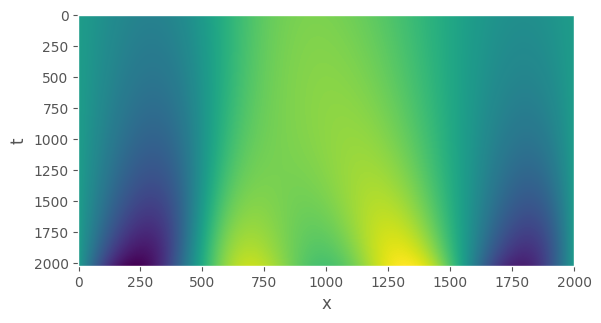

In [3]:
plt.imshow(sols[::-1],aspect = 0.5)
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)

In [4]:
interp = RectBivariateSpline(tvals,grid,sols)
def u_true_function(x):
    return interp(x[:,0],x[:,1],grid = False)

def ut_true_function(x):
    ut_interp = interp.partial_derivative(1,0)
    return ut_interp(x[:,0],x[:,1],grid = False)

In [5]:
def build_tx_grid(t_range,x_range,num_grid_t,num_grid_x):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary

def build_tx_grid_chebyshev(t_range,x_range,num_grid_t,num_grid_x):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    nodes = jnp.cos(jnp.pi*(2*jnp.arange(0,num_grid_x,1)[::-1])/(2*(num_grid_x-1)))
    reg_grid = jnp.linspace(-1,1,num_grid_x)
    alpha = 0.6
    nodes = alpha * nodes + (1-alpha) * reg_grid
    # nodes = jnp.sign(nodes)*jnp.abs(nodes)**(5/4)
    full_x_grid = (nodes  + (x_range[0]+1))/(2*(x_range[1]-x_range[0]))
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary


In [6]:
num_grid_x = 26
num_grid_t = 26

tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x)

tx_all = jnp.vstack([tx_bdy,tx_int])

init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)
final_obs_inds = jnp.where(tx_int[:,0]==1)[0][::1]

u_true = u_true_function(tx_all)

num_obs = 40
np.random.seed(40)

remaining_inds = list(
    set(list(np.arange(len(tx_int)))) - 
    set(list(np.where(tx_int[:,0]==0)[0]))
)
x_t_sample_inds = jnp.hstack([init_obs_inds,final_obs_inds])

tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])

u_obs = u_true_function(tx_obs)


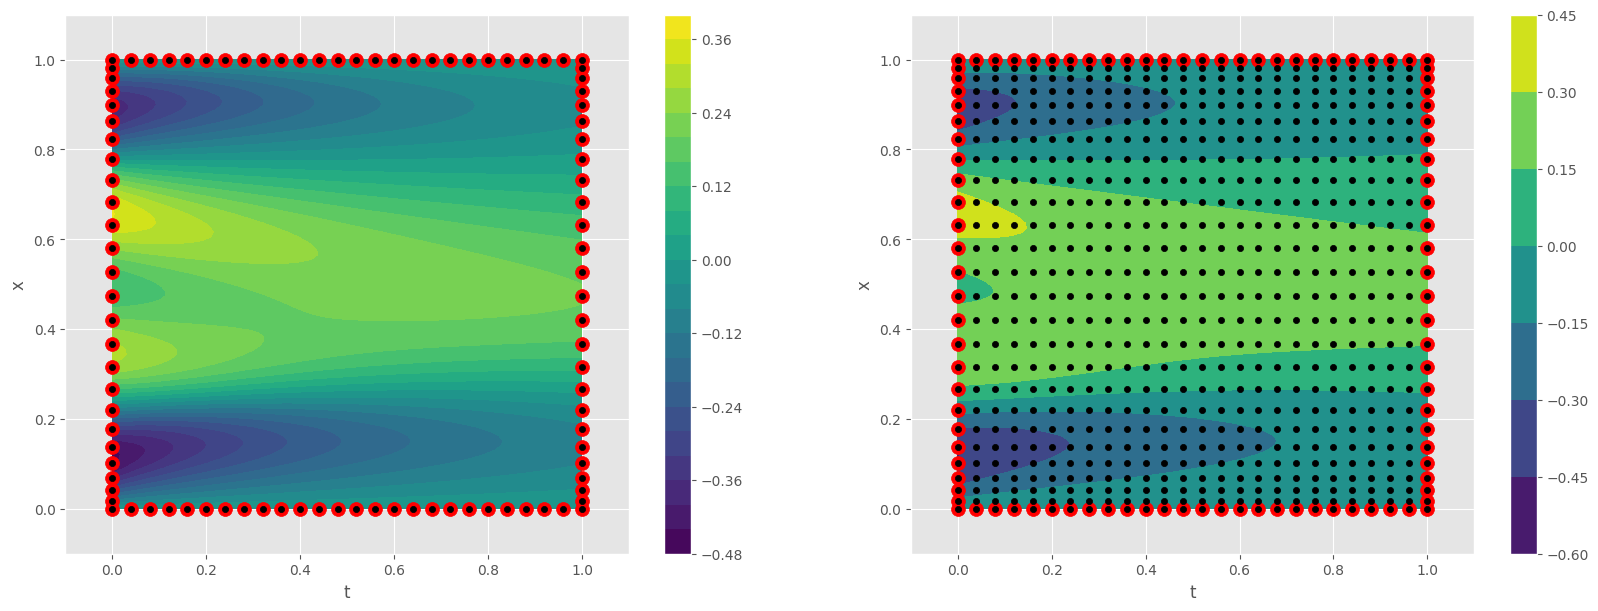

In [7]:
num_fine_grid = 100
final_time = 1
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 20)


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.subplot(1,2,2)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine))
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)

plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 20)


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

Text(0.5, 1.0, 'Input Data')

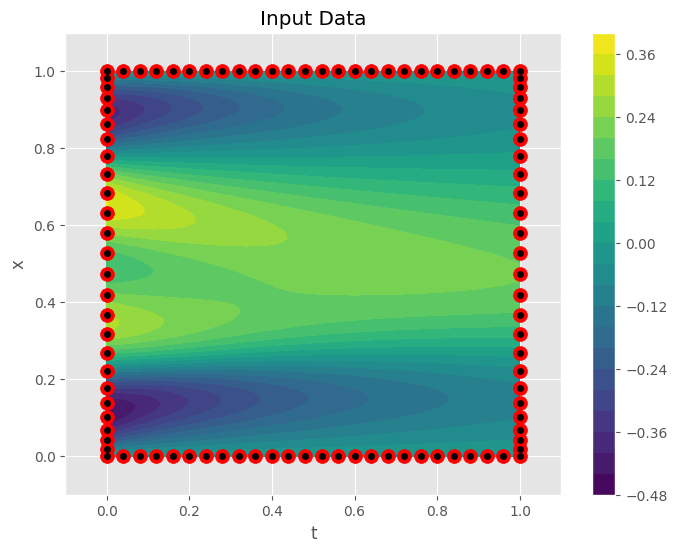

In [8]:
plt.figure(figsize=(8,6))
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 20)
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Input Data")

In [9]:
# Kt = get_kernel_block_ops(get_gaussianRBF(0.001),[eval_k],[eval_k])(jnp.linspace(0,1,500),jnp.linspace(0,1,500))
# samples = np.random.multivariate_normal(jnp.zeros(len(Kt)),Kt,10)
# plt.figure(figsize=(24,5))
# for s in samples[:2]:
#     plt.plot(jnp.linspace(0,1,500),s)

# Kt = get_kernel_block_ops(get_gaussianRBF(0.001),[eval_k],[eval_k])(jnp.linspace(0,1,26),jnp.linspace(0,1,500))
# plt.figure(figsize=(20,5))
# for krow in Kt:
#     plt.plot(krow)

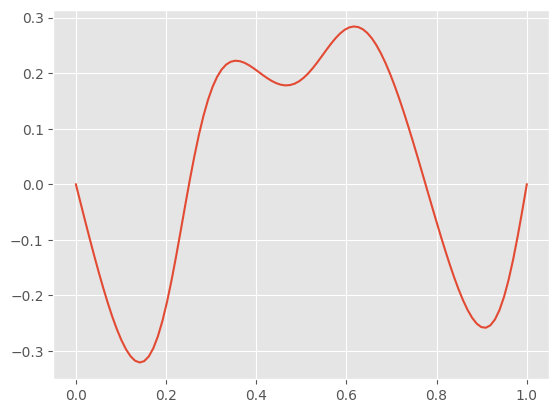

In [10]:
grid_points = jnp.linspace(0,1,100)
plot_views = jnp.vstack([0.2*jnp.ones(100),grid_points]).T

plt.plot(grid_points,u_true_function(plot_views))

In [11]:
jnp.sqrt(0.0125)

Array(0.1118034, dtype=float64, weak_type=True)

In [144]:
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel,get_matern

u_operators = tuple([eval_k,dx_k,dt_k])
feature_operators = tuple([eval_k,dx_k,dxx_k])


k_u = get_matern(12,jnp.sqrt(0.025/2))#get_sum_of_kernels([get_gaussianRBF(0.05),get_gaussianRBF(0.2)],coefficients=[0.5,0.5])#get_gaussianRBF(0.1)

u_model = InducedRKHS(
    tx_all,
    feature_operators,
    k_u
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )
    num_params = len(grid_features_init)

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params

In [145]:
from EquationModel import OperatorPDEModel

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

In [146]:
# init_feats = EqnModel.get_stacked_eqn_features((u_params_init,))
# KP_init = P_model.kernel_function(init_feats,init_feats)
# P_params_init = solve(KP_init+1e-4 * diagpart(KP_init),EqnModel.get_overall_rhs(u_params_init))

In [147]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack([u_params_init,jnp.zeros(P_model.num_params)])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-8,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    cmin = 0.05
)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.1902, Jres = 220.3, alpha = 0.1, improvement_ratio = 0.4367
Iteration 1, loss = 0.06694, Jres = 1.066e+03, alpha = 0.1, improvement_ratio = 0.6722
Iteration 2, loss = 0.03313, Jres = 1.356e+03, alpha = 0.1, improvement_ratio = 0.5409
Iteration 3, loss = 0.004478, Jres = 1.233e+03, alpha = 0.08333, improvement_ratio = 0.9412
Iteration 4, loss = 0.001859, Jres = 376.4, alpha = 0.06944, improvement_ratio = 0.8976
Iteration 5, loss = 0.001066, Jres = 160.8, alpha = 0.05787, improvement_ratio = 0.9997
Iteration 50, loss = 4.152e-06, Jres = 0.6633, alpha = 1.582e-05, improvement_ratio = 0.9028
Line Search Failed!
Final Iteration Results
Iteration 83, loss = 1.337e-06, Jres = 0.0006656, alpha = 0.02745


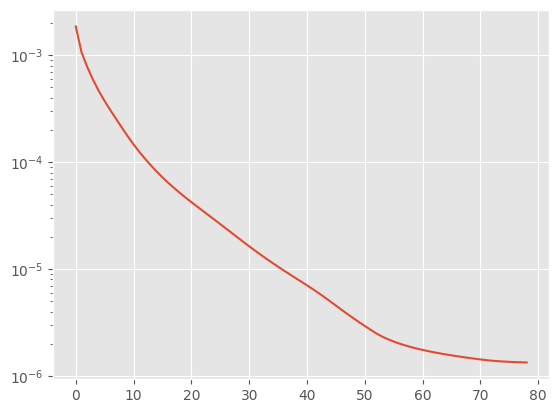

In [148]:
plt.plot(loss_vals[5:])
plt.yscale('log')

In [17]:
hess_loss = jit(jax.hessian(EqnModel.loss))
gradloss = jit(jax.grad(EqnModel.loss))

In [149]:
importlib.reload(LM_Solve)
from LM_Solve import refine_solution
reg_sequence = np.hstack(
    [
        10 ** jnp.arange(-3, -5, -0.1),
        5e-6 * np.ones(30),
        1e-6 * np.ones(30),
        10 ** jnp.arange(-5, -10, -0.1),
        10 ** jnp.arange(-6, -10, -0.05),
        10 ** jnp.arange(-6, -10, -0.05),
        # 5e-11 * jnp.ones(50),
        # 1e-12 * jnp.ones(20),
        # 1e-14 * jnp.ones(20),
        # 1e-15 * jnp.ones(25),
        # 2e-16 * jnp.ones(100),
        # 1e-16 * jnp.ones(100)
        ]
        )
p_adjusted1,refinement_losses = refine_solution(params,EqnModel,reg_sequence)

  0%|          | 0/290 [00:00<?, ?it/s]

In [150]:
p_adjusted,new_refinement_losses = refine_solution(p_adjusted1,EqnModel,
jnp.hstack([
    8e-11*jnp.ones(50),5e-10*jnp.ones(20),
    1e-10*jnp.ones(20),5e-11*jnp.ones(20),
    1e-10*jnp.ones(100),5e-11*jnp.ones(100),
    1e-10*jnp.ones(100),1e-10*jnp.ones(100)
    ])
)


  0%|          | 0/510 [00:00<?, ?it/s]

In [151]:
refinement_losses_combined = jnp.hstack([refinement_losses,new_refinement_losses])

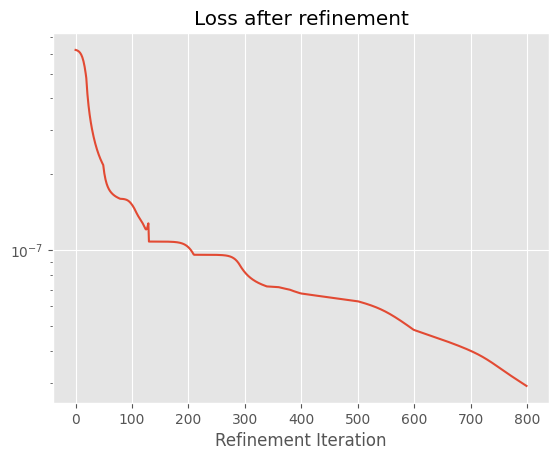

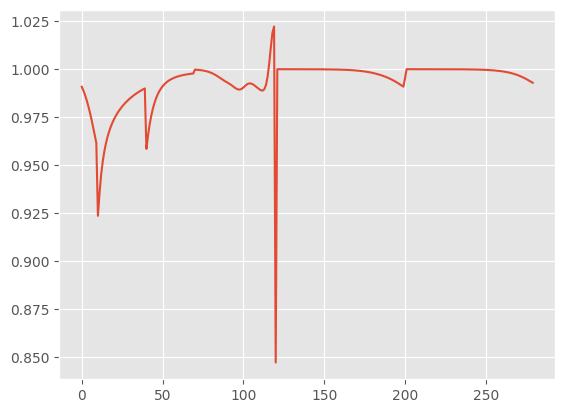

In [152]:
plt.plot(refinement_losses_combined)
plt.xlabel("Refinement Iteration")
plt.title("Loss after refinement")
plt.yscale('log')
plt.show()
plt.plot(refinement_losses[10:]/refinement_losses[9:-1])



/tmp/ipykernel_239170/2671336413.py:1: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([loss_vals,refinement_losses_combined]))


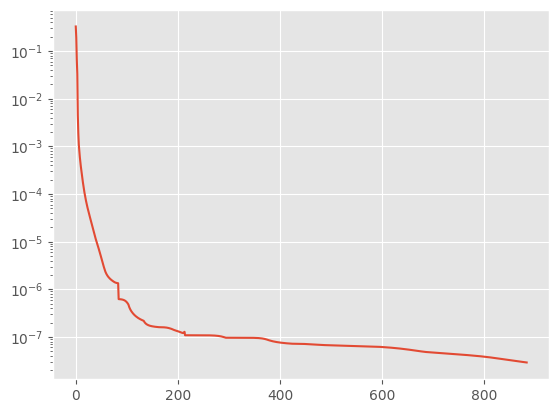

In [153]:
plt.plot(jnp.hstack([loss_vals,refinement_losses_combined]))
plt.yscale('log')

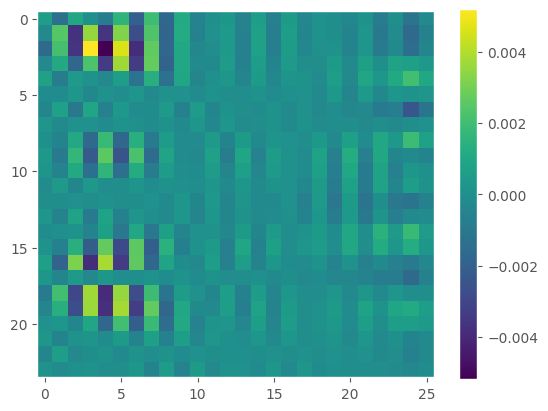

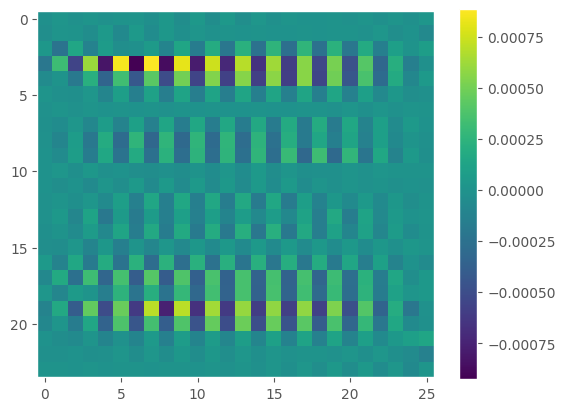

Pre Refinement  1.1525708996295231e-06
Post Refinement  5.678372414510758e-08


In [154]:
equation_residuals = EqnModel.equation_residual(params)
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()

equation_residuals_refined = EqnModel.equation_residual(p_adjusted)
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()
print("Pre Refinement ",jnp.mean(equation_residuals**2))
print("Post Refinement ",jnp.mean(equation_residuals_refined**2))

## Preconditioned gradient descent isn't that good (without some more tuning?)

In [200]:
beta = 1e-8

@jax.jit
def model_loss(params):
    return 0.5 * EqnModel.loss(params) + 0.5 * beta * params.T@damping_matrix@params

grad_model = jax.jit(jax.grad(model_loss))

J = EqnModel.jac(params)
residuals = EqnModel.F(params)
damping_matrix = EqnModel.damping_matrix(params)
loss = jnp.sum(residuals**2) + beta * params.T@damping_matrix@params

JtJ = J.T@J
rhs = J.T@residuals + beta * damping_matrix@params


In [190]:
grad_model(params) - rhs

Array([-1.28556275e-19, -3.77607950e-20, -4.34369083e-19, ...,
        8.13152663e-20, -1.35524238e-20,  9.48681037e-20], dtype=float64)

In [271]:
ev = jnp.linalg.eigvalsh(JtJ + 1e-7 * diagpart(JtJ))

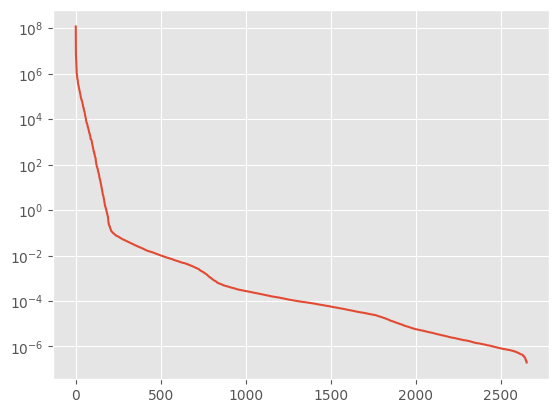

In [272]:
plt.plot(ev[::-1])
plt.yscale('log')

In [254]:
alpha = 1e-5

M = JtJ + (alpha + beta) * damping_matrix
step = solve(M,rhs,assume_a = 'pos')

new_params = params - step
new_reg_norm = beta * new_params.T@damping_matrix@new_params
new_loss = jnp.sum(EqnModel.F(new_params)**2) + new_reg_norm
predicted_loss = jnp.sum((J@step-residuals)**2) + beta * new_reg_norm
decrease = loss - new_loss
model_decrease = loss - predicted_loss
improvement_ratio = decrease/model_decrease

def get_decrease(alpha):
    M = JtJ + (alpha + beta) * damping_matrix
    #step = solve(M,rhs,assume_a = 'pos')
    cho = jax.scipy.linalg.cho_factor(M)
    step = jax.scipy.linalg.cho_solve(cho,rhs)
    new = params - step
    for i in range(20):
        new = new - 0.1 * jax.scipy.linalg.cho_solve(cho,grad_model(new))
        print(model_loss(new))


    new_params = params - step
    new_params = new
    new_reg_norm = beta * new_params.T@damping_matrix@new_params
    new_loss = jnp.sum(EqnModel.F(new_params)**2) + new_reg_norm
    predicted_loss = jnp.sum((J@step-residuals)**2) + beta * new_reg_norm
    decrease = loss - new_loss
    model_decrease = loss - predicted_loss
    return decrease,model_decrease

In [255]:
get_decrease(2e-4)

1.3363887249341566e-06
1.3363562294320317e-06
1.3363237384396134e-06
1.3362912519477532e-06
1.3362587699565677e-06
1.3362262924608828e-06
1.3361938194627118e-06
1.3361613509560452e-06
1.3361288869369973e-06
1.3360964274071415e-06
1.3360639723589958e-06
1.3360315217973954e-06
1.3359990757156545e-06
1.3359666341120642e-06
1.3359341969893334e-06
1.3359017643405382e-06
1.3358693361681616e-06
1.335836912468752e-06
1.3358044932402203e-06
1.3357720784839151e-06


(Array(1.94901295e-09, dtype=float64), Array(1.3032173e-07, dtype=float64))

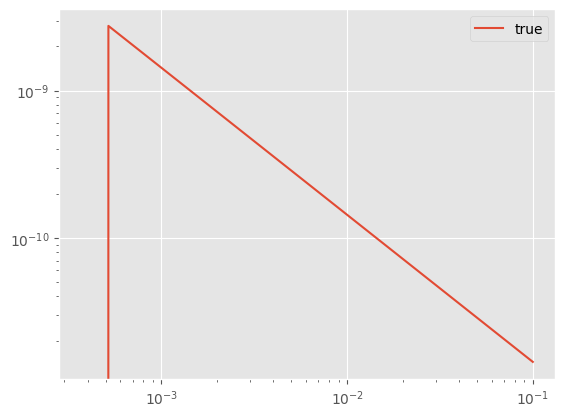

In [232]:
plt.plot(alpha_vals,decrease[:,0],label = 'true')
#plt.plot(alpha_vals,decrease[:,1],label = 'model')
plt.legend()
plt.xscale('log')
plt.yscale('log')

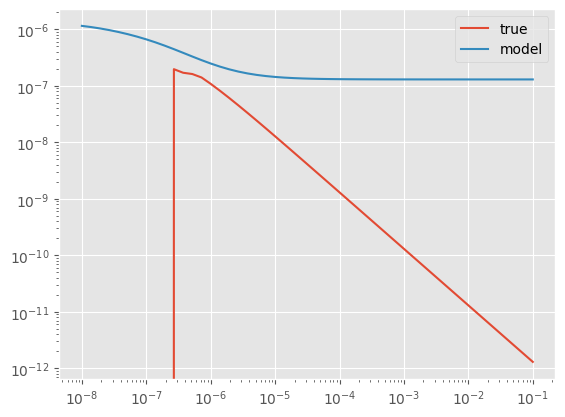

In [203]:
plt.plot(alpha_vals,decrease[:,0],label = 'true')
plt.plot(alpha_vals,decrease[:,1],label = 'model')
plt.legend()
plt.xscale('log')
plt.yscale('log')

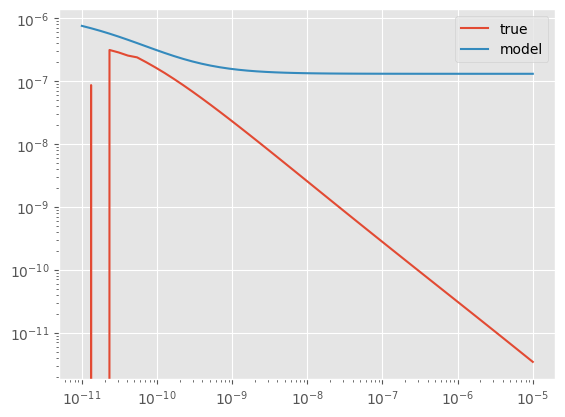

In [134]:
plt.plot(alpha_vals,decrease[:,0],label = 'true')
plt.plot(alpha_vals,decrease[:,1],label = 'model')
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [80]:
improvement_ratio

Array(0.09752951, dtype=float64)

In [65]:
minv = jnp.linalg.inv(M)
step_inv = minv@rhs
res = rhs - M@step_inv
alt_error = M@(step_inv + minv@res) - rhs
step = step_inv + minv@res
step = step_inv


In [63]:
M@step_inv - rhs

Array([-8.05523567e-14, -9.85749884e-14, -9.81471099e-14, ...,
       -1.12678209e-14, -7.21017583e-15, -1.69808341e-14], dtype=float64)

In [66]:
res = rhs - M@step_inv

Array([-5.05276614e-16,  6.83273751e-17,  2.10602925e-15, ...,
        2.78498566e-16, -9.92926890e-16, -1.60955270e-16], dtype=float64)

In [58]:
(loss - new_loss)/(loss - predicted_loss)

Array(0.09752937, dtype=float64)

  0%|          | 0/500 [00:00<?, ?it/s]

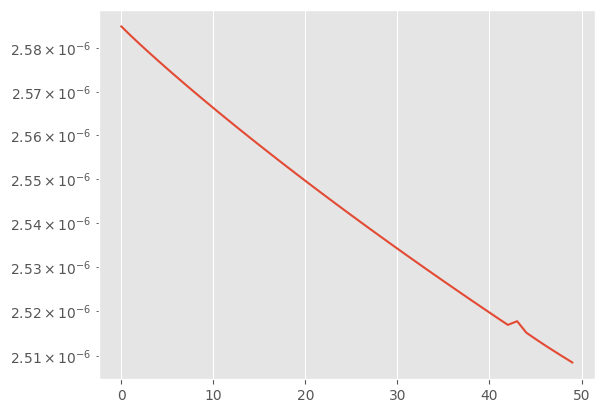

In [28]:
J = EqnModel.jac(params)

U,sigma,Vt = jnp.linalg.svd(J, full_matrices=False)
PC = Vt.T@ jnp.diag(1/jnp.sqrt(sigma**2 + 1e-16))@Vt

PC_inv = Vt.T@ jnp.diag(jnp.sqrt(sigma**2 + 1e-2))@Vt
P = Vt.T@ jnp.diag(1/(sigma**2 + 1e-2))@Vt
def pc_loss_func(x):
    return EqnModel.loss(x)

loss_val_grad = jax.jit(jax.value_and_grad(pc_loss_func))
x = params.copy()
val,g = loss_val_grad(x)
x = params.copy()
loss_vals = []
for i in tqdm(range(500)):
    value,g = loss_val_grad(x)
    loss_vals.append(value)
    x = x - 0.5 * P@g

plt.plot(loss_vals[::10])
plt.yscale("log")
    

In [122]:
val - loss_vals[-1]

Array(-8.85220004e-08, dtype=float64)

In [ ]:
# analyze_hessian(hess_loss(p_adjusted),gradloss(p_adjusted))

In [155]:
# u_sol = params[:u_model.num_params]
# P_sol = params[u_model.num_params:]

# u_sol = p_adjusted[:u_model.num_params]
# P_sol = p_adjusted[u_model.num_params:]

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

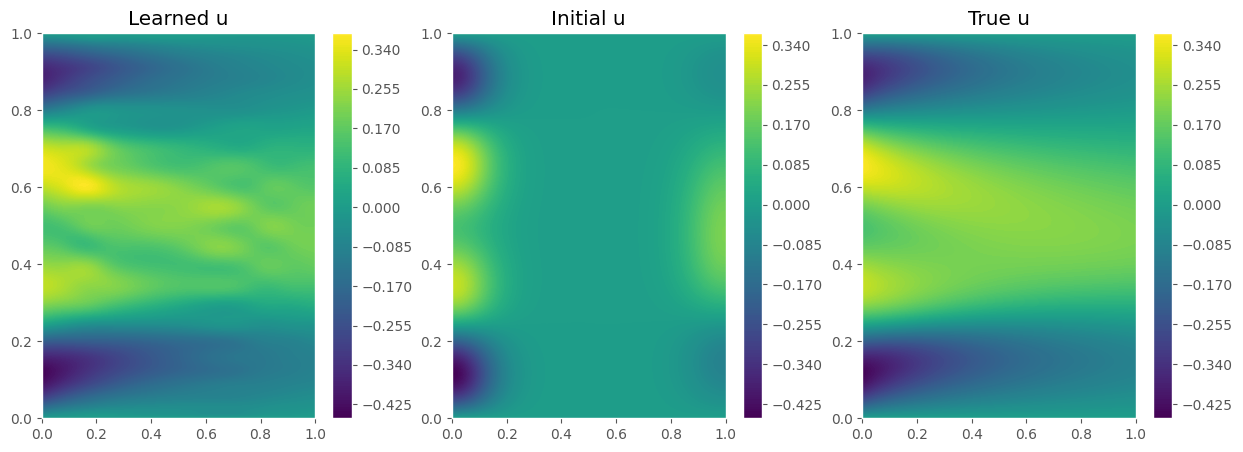

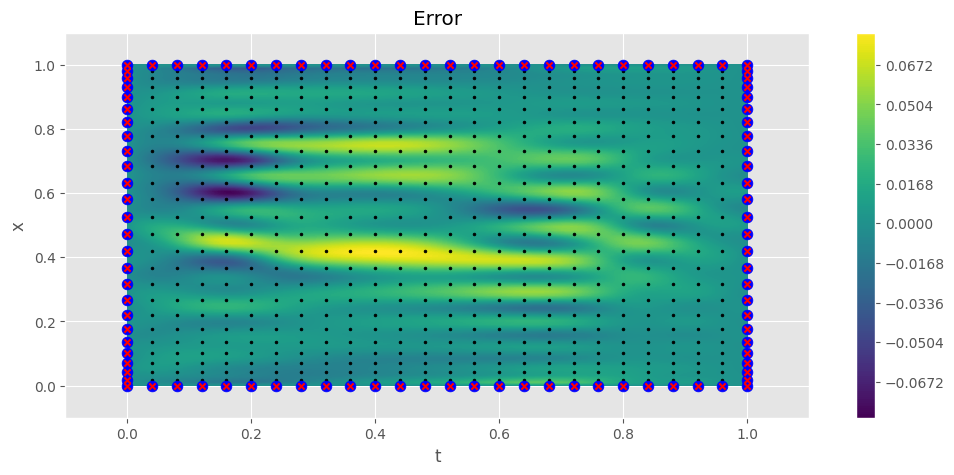

In [156]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)

u_true_fine = u_true_function(tx_grid_fine)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Learned u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_eval_fine,200)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Initial u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_model.point_evaluate(tx_grid_fine,u_params_init),200)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine,200)
plt.colorbar()

plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='blue',s = 60)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 20,marker = 'x')


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [157]:
def compare_values(x,y):
    plt.plot([np.min(x),np.max(x)],
            [np.min(x),np.max(x)],c = 'blue',lw = 0.8)
    plt.scatter(x,y,c = 'black',s = 4)


In [158]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
# hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = interp.partial_derivative(1,0)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
ux_true = interp.partial_derivative(0,1)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
uxx_true = interp.partial_derivative(0,2)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)


true_features = jnp.vstack([u_true_interior,ux_true,uxx_true]).T
true_features = jnp.hstack([tx_fine_int,true_features])

model_grid_features = EqnModel.get_stacked_eqn_features((u_sol,))
model_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_fine_int)
#model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_stacked_eqn_features((u_params_init,))

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.get_stacked_rhs_op((u_params_init,)))

init_P_features_fine = u_model.evaluate_operators(feature_operators,tx_fine_int,u_params_init).reshape(len(tx_fine_int),len(feature_operators),order = 'F')
P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

2024-05-04 00:29:26.841622: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 4s:

  %reduce.32 = f64[10000,676]{1,0} reduce(f64[10000,676,2]{2,1,0} %broadcast.1036, f64[] %constant.56), dimensions={2}, to_apply=%region_32.335, metadata={op_name="jit(get_single_eqn_features)/jit(main)/jit(evaluate_operators)/reduce_sum[axes=(2,)]" source_file="/home/alexh/KEQL/keql/keql_tools/Kernels.py" source_line=103}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-05-04 00:29:35.211457: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 12.369921455s
Constant folding an instr

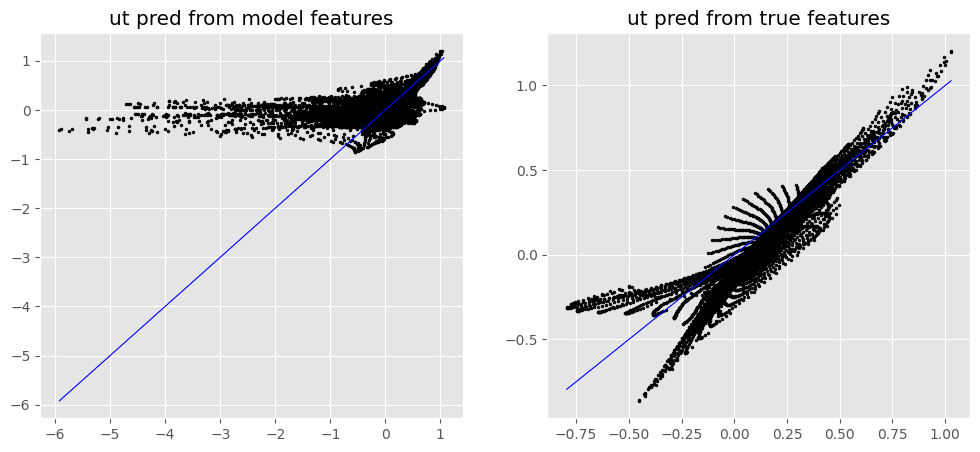

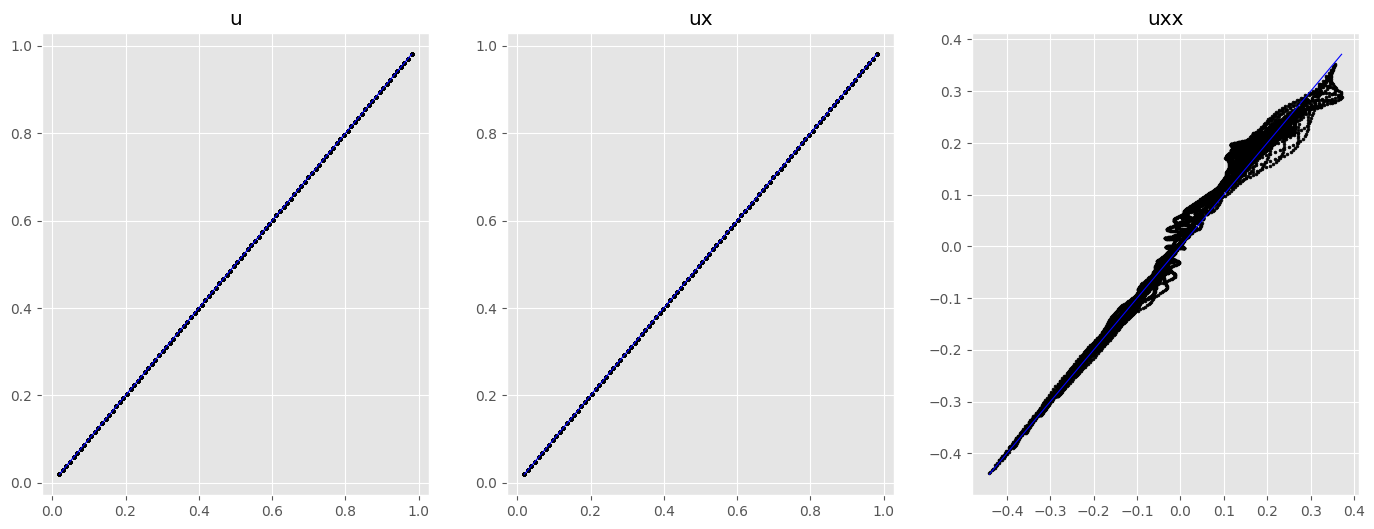

In [159]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('ut pred from model features')
compare_values(preds_ut_model_features,ut_true)
plt.subplot(1,2,2)
plt.title('ut pred from true features')
compare_values(preds_ut_true_features,ut_true)
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(1,3,1)
plt.title('u')
compare_values(model_features[:,0],true_features[:,0])
plt.subplot(1,3,2)
plt.title('ux')
compare_values(model_features[:,1],true_features[:,1])
plt.subplot(1,3,3)
plt.title("uxx")
compare_values(model_features[:,2],true_features[:,2])
plt.show()


In [160]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

def get_clipped_nrmse(true,pred, perc = 1):
    pred_clipped = jnp.clip(pred,jnp.percentile(pred,perc),jnp.percentile(pred,100-perc))
    true_clipped = jnp.clip(true,jnp.percentile(true,perc),jnp.percentile(true,100-perc))
    return get_nrmse(true_clipped,pred_clipped)


def get_nmae(true,pred):
    return jnp.mean(jnp.abs(true-pred))/jnp.mean(jnp.abs(true))

print("Normalized RMSE")
print("Optimized model feature predictions ",get_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features_init))

print("Clipped Normalized RMSE")
print("Optimized model feature predictions ",get_clipped_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_clipped_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features_init))


print("Normalized MAE")
print("Optimized model feature predictions ",get_nmae(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nmae(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nmae(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nmae(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nmae(ut_true,P_preds_init_model_features_init))

Normalized RMSE
Optimized model feature predictions  3.118191228896556
Optimized true feature predictions  0.49036200241648586
2 step model feature predictions  30.02364811190485
2 step true feature predictions  2.3876953694895304
2 step init model feature predictions  24873.269796374156
Clipped Normalized RMSE
Optimized model feature predictions  3.0544607929172667
Optimized true feature predictions  0.48098029639815026
2 step model feature predictions  28.903143774418695
2 step true feature predictions  2.3933168936696334
2 step init model feature predictions  22832.44889724093
Normalized MAE
Optimized model feature predictions  2.1442422133797554
Optimized true feature predictions  0.5088973739800281
2 step model feature predictions  19.02052443132371
2 step true feature predictions  2.289790294875014
2 step init model feature predictions  9241.47317550412


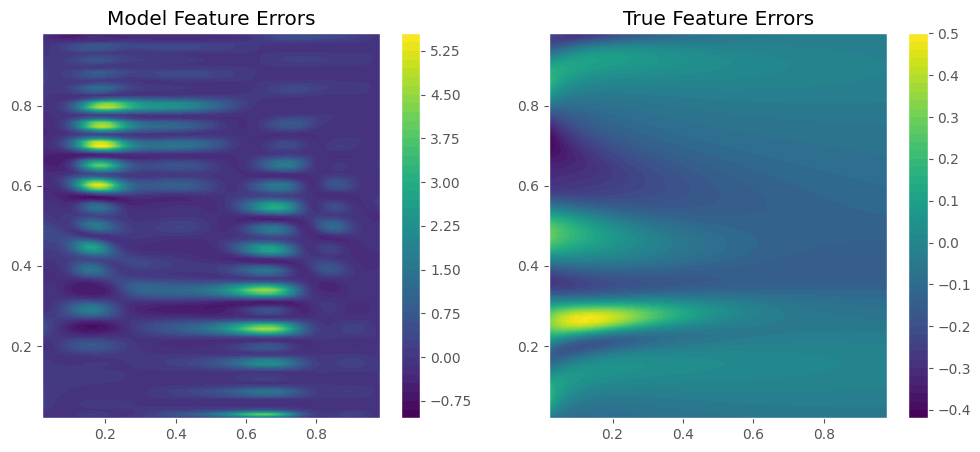

In [161]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Model Feature Errors")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,50,)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("True Feature Errors")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_true_features,50,)
plt.colorbar()

plt.show()

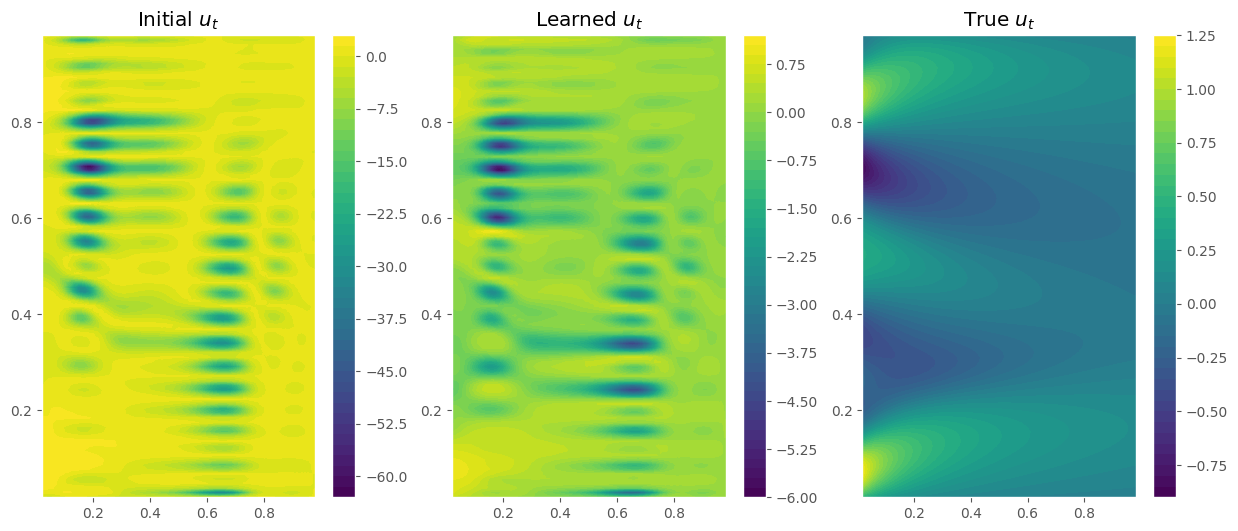

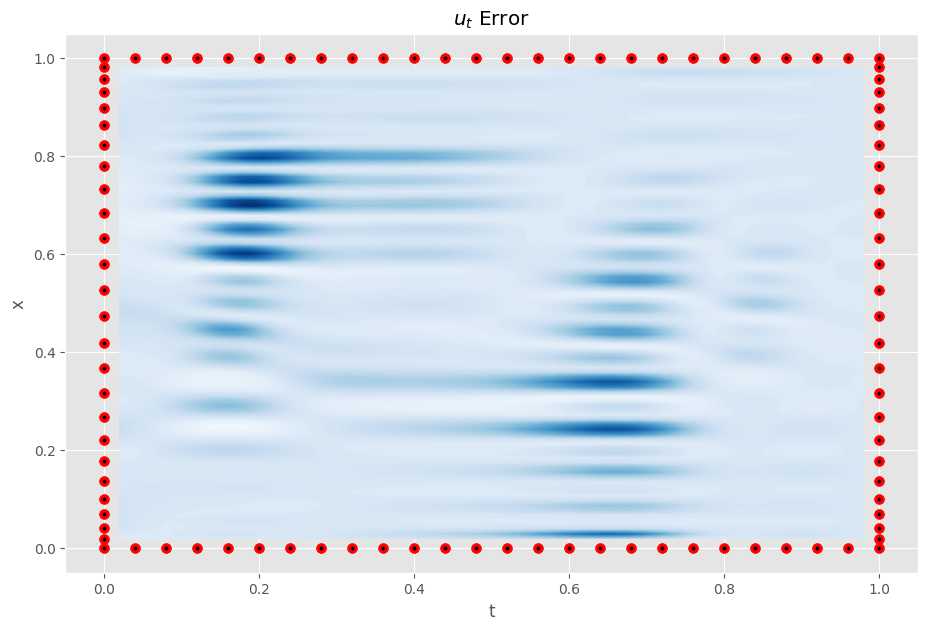

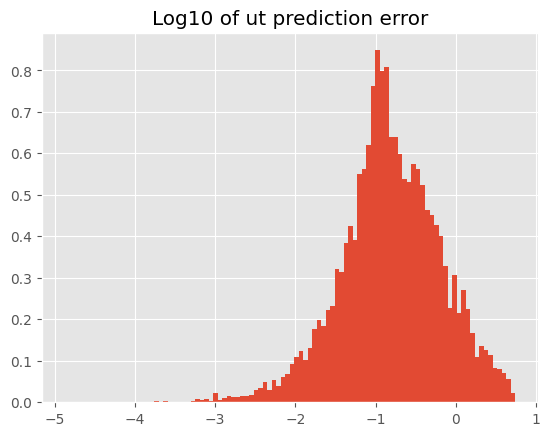

In [162]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)

plt.title("Initial $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],P_preds_init_model_features,50)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Learned $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],preds_ut_model_features,50,)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true,50)
plt.colorbar()

plt.show()
plt.figure(figsize=(11,7))
plt.title("$u_t$ Error")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,100,cmap = 'Blues')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50,label = 'Given value of u(t,x)')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 5,label = 'Given value of u(t,x)')

#plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.xlabel("t")
plt.ylabel("x")
plt.show()
plt.title("Log10 of ut prediction error")
plt.hist(jnp.log10(jnp.abs(ut_true-preds_ut_model_features) + 1e-20),100,density = True)
plt.show()

## Test on a new initial condition

  0%|          | 0/2019 [00:00<?, ?it/s]

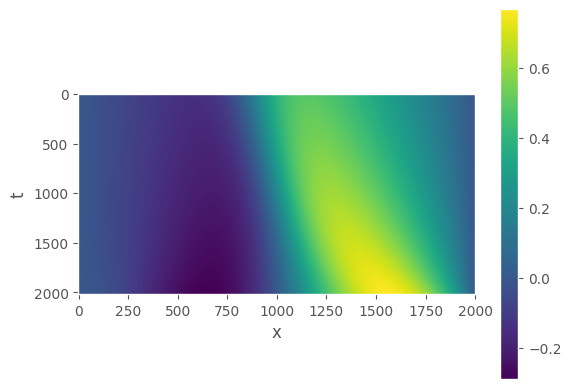

In [163]:
k = 5e-4
kappa = 0.01
alpha = 0.5
def new_func_u0(x):
    u0 = -1 * x * jnp.sin(2 * jnp.pi * x)
    return u0

grid,solver = get_burger_solver(alpha,kappa,k,n = 1999)

u0_new = new_func_u0(grid)[1:-1]

sols_new,tvals = solver(u0_new,1.01)
sols_new = np.hstack([np.zeros((len(sols_new),1)),sols_new,np.zeros((len(sols_new),1))])

new_interp = RectBivariateSpline(tvals,grid,sols_new)
def new_u_true_function(x):
    return new_interp(x[:,0],x[:,1],grid = False)


plt.imshow(sols_new[::-1],aspect = 0.5)
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.colorbar()

In [164]:
@jit
def get_pred_ut(input_features):
    return P_model.kernel_function(input_features,model_grid_features)@P_sol
tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])

new_obs = new_u_true_function(tx_init_bdy)


class PdeModel():
    datafit_weight = 25.
    @jit
    def get_grid_features(u_params):
        evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
        grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
        return jnp.hstack([tx_int,grid_features])
    
    @jit
    def get_grid_target(u_params):
        return u_model.evaluate_operators((dt_k,),tx_int,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(tx_init_bdy,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = PdeModel.eval_obs_points(u_params)
        return new_obs - obs_preds
    
    @jit
    def equation_residual(u_params):
        P_features = PdeModel.get_grid_features(u_params)
        P_model_preds = get_pred_ut(P_features)
        ugrid_target = PdeModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(u_params):
        eqn_res = PdeModel.equation_residual(u_params)
        data_res = PdeModel.datafit_residual(u_params)
        return jnp.hstack([
            PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(u_params):
        return jnp.linalg.norm(PdeModel.F(u_params))**2
    
    @jit
    def damping_matrix(u_params):
        return u_model.kmat+1e-5 * diagpart(u_model.kmat)

In [165]:
new_u_init = 0*u_sol

u_params_pde,loss_vals_pde,JtRes_pde,improvement_ratios_pde,alpha_vals_pde,iterate_history_pde = LevenbergMarquadtMinimize(
    new_u_init.copy(),
    PdeModel,
    beta = 0.,
    max_iter = 101,
    init_alpha=0.05,
    line_search_increase_ratio=1.4,
    print_every = 10
)

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.1524, Jres = 4.572e+03, alpha = 0.04167, improvement_ratio = 0.9965
Iteration 1, loss = 0.03889, Jres = 107.9, alpha = 0.03472, improvement_ratio = 0.9199
Iteration 2, loss = 0.0194, Jres = 21.85, alpha = 0.02894, improvement_ratio = 1.036
Iteration 3, loss = 0.01274, Jres = 7.227, alpha = 0.02411, improvement_ratio = 1.03
Iteration 4, loss = 0.009715, Jres = 3.683, alpha = 0.02009, improvement_ratio = 1.043
Iteration 5, loss = 0.008023, Jres = 2.095, alpha = 0.01674, improvement_ratio = 1.054
Iteration 10, loss = 0.00506, Jres = 0.4664, alpha = 0.006729, improvement_ratio = 1.06
Iteration 20, loss = 0.00341, Jres = 0.1079, alpha = 0.001087, improvement_ratio = 1.01
Iteration 30, loss = 0.0019, Jres = 0.03578, alpha = 0.0001755, improvement_ratio = 1.004
Iteration 40, loss = 0.000292, Jres = 0.08763, alpha = 2.835e-05, improvement_ratio = 1.004
Iteration 50, loss = 5.067e-05, Jres = 0.01448, alpha = 4.579e-06, improvement_ratio = 1.006
Iteration 60, loss = 3.006e-

In [166]:
reg_sequence = np.hstack(
    [
        10 ** jnp.arange(-4, -11, -0.25),
        5e-12 * np.ones(10),
        1e-15 * np.ones(5),
        5e-16 * np.ones(15),
        1e-16 * np.ones(15),
        ]
        )
u_pde_adj,refinement_losses_pde = refine_solution(u_params_pde,PdeModel,reg_sequence)


  0%|          | 0/73 [00:00<?, ?it/s]

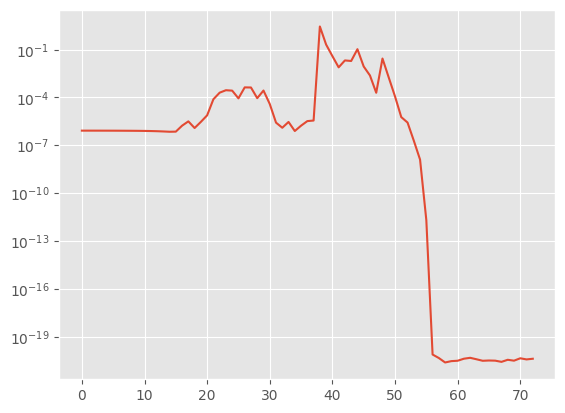

In [167]:
plt.plot(refinement_losses_pde)
plt.yscale('log')

In [168]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(final_time,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

new_u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_pde_adj)

new_u_true_fine = new_u_true_function(tx_grid_fine)
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.title("solved u")
# plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_eval_fine,200)
# plt.colorbar()
# plt.subplot(1,2,2)
# plt.title("True u")
# plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine,200)
# plt.colorbar()


In [169]:
# plt.figure(figsize=(12,8))
# plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine-new_u_eval_fine,200)
# plt.colorbar()
# plt.scatter(tx_all[:,0],tx_all[:,1],s = 3,c='black')
# plt.xlim(-0.01,1.01)
# plt.ylim(-0.01,1.01)
# plt.title("Error")

In [170]:
get_nrmse(new_u_true_fine,new_u_eval_fine)

Array(0.59896581, dtype=float64)

In [171]:
jnp.max(jnp.abs(new_u_true_fine-new_u_eval_fine))

Array(0.36002952, dtype=float64)

In [47]:
get_nrmse(new_u_true_fine,new_u_eval_fine)

Array(0.02365051, dtype=float64)

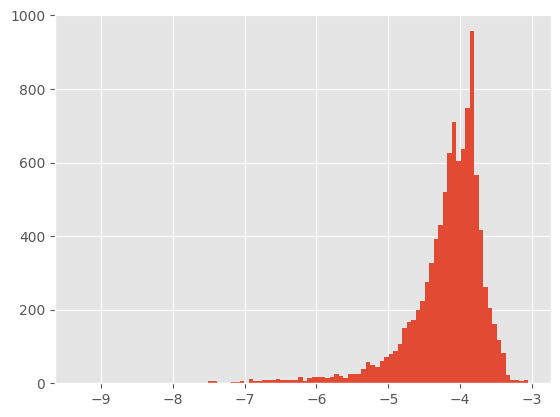

In [236]:
plt.hist(jnp.log10(jnp.abs(new_u_true_fine-new_u_eval_fine)),100)
plt.show()